In [1]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from ionoptics import geometry as geo
from ionoptics import beamline as bl
from ionoptics import bmad

# for presentation
#plt.rcParams.update({'font.size': 25})
#plt.rcParams.update({'lines.linewidth': 3})

In [2]:
# beamsize
##JULIC
### 1 sigma x = 6 mm
### 1 sigma y = 9 mm

##HBS LINAC
### diameter ~ 10 mm (6 sigma)
### 1 sigma = 1.5 mm

sigma_x = 2.27e-3

## quadrupole position evaluation

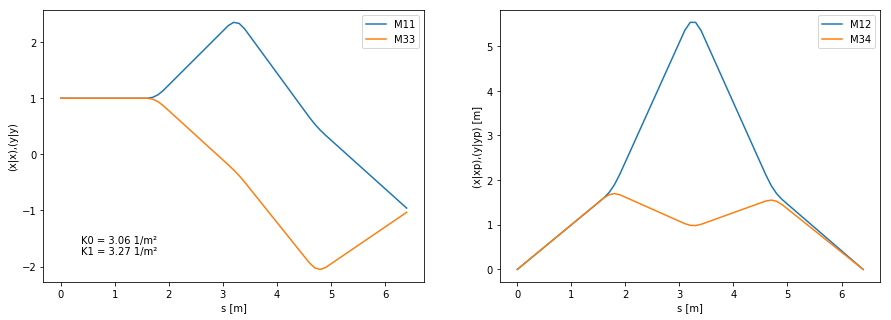

total length:  6.5


In [5]:
l = 1.6 # from object to 1st q
L_Fe = 0.3 # q thickness
L = 0.3
d = 1.2 # dist. betw. q's

k0,k1 = bl.opt_quad_mult(l,L_Fe,[d,d],[2,3])

lengths = [l,L_Fe,d,L_Fe,d,L_Fe,l]
elements = [bl.drift,partial(bl.qdf, k=k0),bl.drift,partial(bl.qf, k=k1),bl.drift,partial(bl.qdf, k=k0),bl.drift]

axes = bl.plot_M_vs_s(elements,lengths,figsize = (15,5))

axes[0].text(0.1,0.1,'K0 = {:.2f} 1/m²\nK1 = {:.2f} 1/m²'.format(k0,k1),transform=axes[0].transAxes)

axes[0].set_ylabel('(x|x),(y|y)')
axes[1].set_ylabel('(x|xp),(y|yp) [m]')

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'QT_eval-{}_{}_{}'.format(l,d,L)
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

print('total length: ', round(2*l+2*d+3*L,2))

### bmad cross check

xmax @  start: 0.008794187512927744
xrms @  start: 0.002270840286715482
xmax @  end: 0.00823911915726471
xrms @  end: 0.002420931706813581
ymax @  start: 0.008324915486026298
yrms @  start: 0.002270840286715489
ymax @  end: 0.0073704853668489735
yrms @  end: 0.00220376005613069


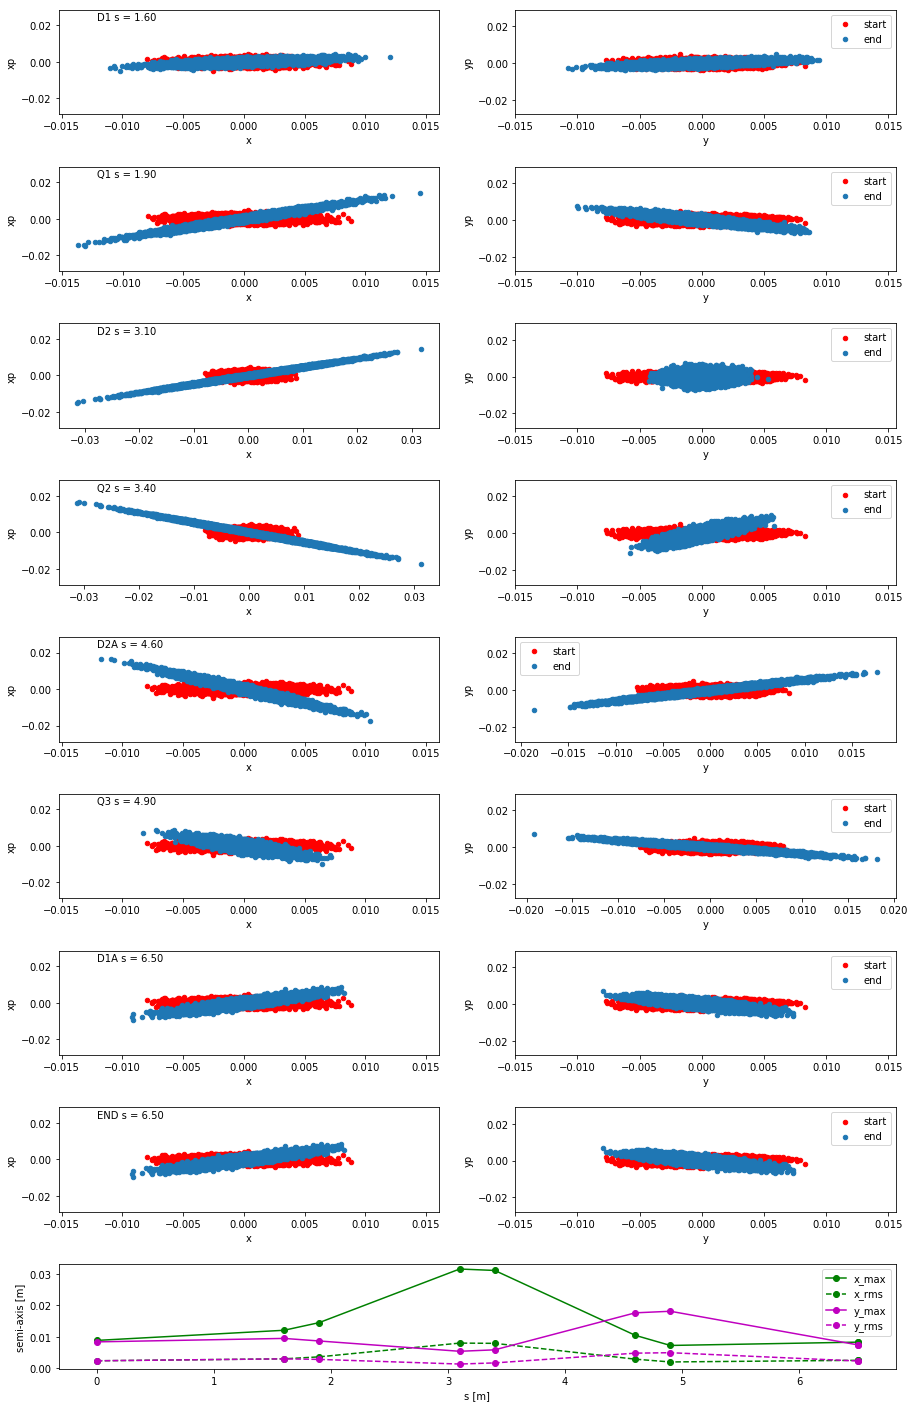

In [7]:
df = bmad.txt_to_df('../../Bmad/Playground/production/bin/','tracking_ele.txt')
bmad.plot_phase_space(df,figsize=(15,25))

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'pure_tr_DFD-{}_{}_{}_sigmax{}'.format(l,d,L,2.54) #TODO: back to dynamic sigma_x
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

## kick-septum angle evaluation - symmetric 2 kicker setup

In [4]:
## beam parameters
Thet_init = 0

## distances
l_object = 0.1 # previous object to kicker (minimum)
l_kick = 0.5
l_sept = 0.75

lkq = d-l_kick-l_object
l_max = d + L + lkq # d: from q to q

## vertical distances
x_init = 0

# at septum
septum = 5e-3
x_sept = 4*sigma_x+septum
# at max prop
x_at_max_prop = 0.6
x_add = x_at_max_prop-x_sept

sept_type = 'OFS'

## iteration

start_kick = 0.001 # smallest kick-angle
step_kick = 0.001 # step size kick-angle

list_perm = np.linspace(0,1,1001) # range of septum anglesenvelope

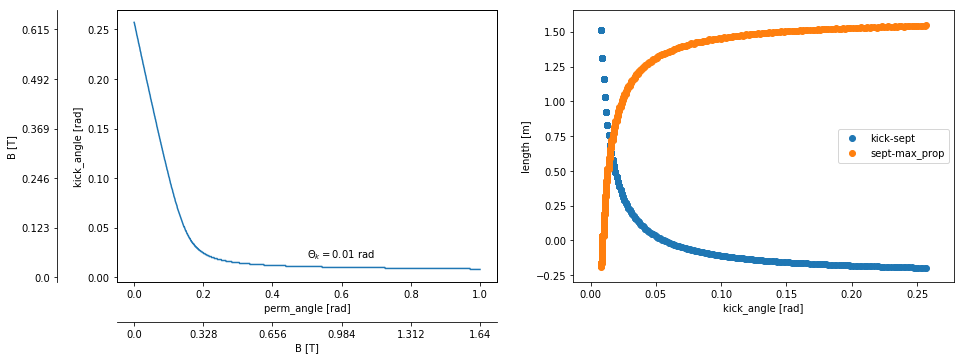

In [5]:
ax,data= geo.plot_comb_kick_sept(x_sept,
                                 x_add,
                                 x_init,
                                 Thet_init,
                                 l_kick,
                                 l_sept,
                                 sept_type,
                                 start_kick,
                                 step_kick,
                                 list_perm,
                                 l_max,
                                 brho=1.23,
                                 figsize = (15,5)
                                )


#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'ang_eval-{}_{}_{}_sx{}_ls{}_lk{}'.format(l_max,x_at_max_prop,sept_type,sigma_x,l_sept,l_kick)
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900, bbox_inches="tight")

plt.show()

In [8]:
kick_d = data[0][0.45]

dks = [d[1] for d in data[1] if d[0] == kick_d]
dks_av = sum(dks)/len(dks)
# kicker-septum


dsf = [d[1] for d in data[2] if d[0] == kick_d]
dsf_av = sum(dsf)/len(dsf)
# septum - final

(kick_d,dks_av,dsf_av,l_max-l_sept)

(0.011, 1.030020771959897, 0.25194042724466964, 1.35)

## reduced kicker strength by quadrupole

In [47]:
kick_d*dks_av+l_kick*kick_d/2

0.014080228491558867

In [10]:
reduced = kick_d - 0.6e-3

if (dks_av-lkq-L)>=0:
    total_defl,new_angle = geo.quad_defl(k1,0.3,reduced,l_kick,lkq,dks_av-lkq-L)
    if total_defl >= (kick_d*dks_av+l_kick*kick_d/2):
        print('kicker-quad:', lkq)
        print('quad-septum:', dks_av-lkq-L)
        print(total_defl)
    print(new_angle-kick_d)
else:
    print('not working!:', dks_av-lkq-L)

kicker-quad: 0.6
quad-septum: 0.13002077195989709
0.014177208638448268
0.008060045442673917


In [11]:
geo.calc_magn(0.45,0.75,1.23)

0.738

## twiss QT study

In [50]:
eps_LINAC = 2.54 # mm mrad
dia_LINAC = 10 # mm (6 sigma)

beta_init = (dia_LINAC/6)**2/eps_LINAC # m

beta = np.linspace(beta_init,10, 20) # m

sigma_X = np.sqrt(eps_LINAC*beta)
sigma_Xp = np.sqrt(eps_LINAC/beta)

sigma_Y = np.sqrt(eps_LINAC*beta)
sigma_Yp = np.sqrt(eps_LINAC/beta)

In [51]:
Ms = bl.Mplot(elements,lengths)

In [52]:
max_rms_x = abs(max(Ms[1][0], key = abs))*sigma_X+abs(max(Ms[1][1], key = abs))*sigma_Xp
max_rms_y = abs(max(Ms[2][0], key = abs))*sigma_Y+abs(max(Ms[2][1], key = abs))*sigma_Yp

squares = np.sqrt(max_rms_x**2+max_rms_y**2)

In [53]:
print(max(Ms[1][0], key = abs))
print(max(Ms[1][1], key = abs))

print(max(Ms[2][0], key = abs))
print(max(Ms[2][1], key = abs))

2.3529415162618394
5.533936028119204
-2.0514191987521015
1.6989504634987098


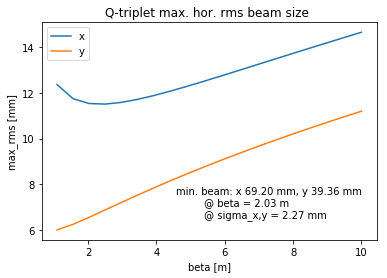

In [55]:
plt.plot(beta,max_rms_x)
plt.plot(beta,max_rms_y)
plt.legend(['x','y'])

plt.xlabel('beta [m]')
plt.ylabel('max_rms [mm]')
plt.text(0.40,0.1,
         '''min. beam: x {:.2f} mm, y {:.2f} mm  
         @ beta = {:.2f} m 
         @ sigma_x,y = {:.2f} mm'''.format(max_rms_x[squares.argmin()]*6,
                                         max_rms_y[squares.argmin()]*6,
                                         beta[squares.argmin()],
                                         sigma_X[squares.argmin()]),
         transform=plt.gca().transAxes)

plt.title('Q-triplet max. hor. rms beam size ')

PATH_TO_DATA = '../../Multiplexer/Plots/'
FILENAME = 'Twiss_Linac_QT_DFD_eval-{:.2f}'.format(eps_LINAC)
plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

In [56]:
squares = np.sqrt(max_rms_x**2+max_rms_y**2)


print(max_rms_x[squares.argmin()]*6)
print(max_rms_y[squares.argmin()]*6)
print(beta[squares.argmin()])
print(sigma_X[squares.argmin()])

69.19696856484711
39.35639000705678
2.0311276879863702
2.271357375554402


In [57]:
print(max_rms_y[3]*6)

41.290932650097034
